## Acknowledgements
This analysis (though not exact code) is inspired by the work of Maksim Ekin Eren (meren1@umbc.edu), and Nick Solovyev (sonic1@umbc.edu).
It can be found [here](https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html).

## Imports

In [1]:
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.decomposition import PCA, SparsePCA, IncrementalPCA
from sklearn.cluster import KMeans
import numpy as np
from nltk.stem import PorterStemmer
import string
import matplotlib.pyplot as plt
# For three dimensional plotting
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv

## Paths to CORD-19 data
Change accordingly.

In [2]:
# Path to general CORD-19 Data on my local machine
path = "/Users/ryersonburdick/Desktop/CORD-19-research-challenge"
# Path to biorxiv/medrxiv articles
biomed = path + "/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json"
# Path to comm use PMC articles
pmc = path + "/comm_use_subset/comm_use_subset/pmc_json"

## Doc Class
We'll use this class to store all information about a particular article included in the CORD-19 dataset (title, authors, paper ID, full text, etc.).

In [3]:
class Doc:
    """
    Stores data from CORD-19 json files in more readable format.

    Attributes:
        id : string
        title : string
        authors : list of string
        text : string
        vec : numpy array
    """

    def __init__(self, json_file):
        """
        Create Doc object from json file from CORD-19 dataset.

        json_file : string
            path to json file from CORD-19 datset
        """

        # Open json file
        doc = json.loads(open(json_file, "r").read())

        # Extract paper id
        self.id = doc["paper_id"]

        # Extract paper title, make lowercase for normalization purposes
        self.title = doc["metadata"]["title"].lower()

        # Extract author data (list of dicts contain first, last, etc.)
        authors = doc["metadata"]["authors"]
        self.authors = [
            author["first"] + " " + " ".join(author["middle"])
            + ("" if author["middle"] == [] else " ") + author["last"]
            for author in authors]

        # Extract all text from abstract
        abstr = ""
        if "abstract" in doc:
            self.abstr = " ".join([par["text"] for par in doc["abstract"]])
        # Extract all paragraphs from body
        body = " ".join([par["text"] for par in doc["body_text"]])
        self.text = abstr + " " + body

        # For storing feature vector
        self.vec = None

## Loading data from CORD-19 Directories

In [4]:
def load_from_dirs(dirs):
    """
    Returns number of articles and list of article info for each article
    in a CORD-19 subdir containing json files.

    dir : list of string
        List of paths to directories containing CORD-19 json files.
    """

    doclist = []
    for dir in dirs:
        print("Reading files from directory: " + dir)
        for file in os.listdir(dir):
            if file.endswith(".json"):
                # Read file text
                fullpath = dir + "/" + file
                # Create Doc object and add to doclist
                doc = Doc(fullpath)
                doclist.append(doc)

    return doclist

## Stemming of Full Document Texts

In [5]:
def stem(doclist, method="porter"):
    """
    Stem full document texts for all documents in doclist.
    
    doclist : list of Doc
        List of Doc objects to stem texts for.
    stemmer : {"porter"}
        Stemmer to use. Default is nltk.stem.PorterStemmer.
    """
    
    if method == "porter":
        stemmer = PorterStemmer()
    # Add other stemmers eventually
    
    for doc in doclist:
        # Split by whitespace
        words = doc.text.split(" ")
        
        # Remove punctuation and make lowercase
        #no_punc = str.maketrans("", "", string.punctuation)
        #words = [word.translate(no_punc).lower() for word in words]
        
        # Stem
        stemmed_words = [stemmer.stem(word) for word in words]
        
        # Rejoin
        doc.text = " ".join(words)
        
    
    
        

## Generating Feature Vectors
This function is meant to generate feature vectors given a list of Doc objects. The only method it currently supports is TF-IDF (term frquency-inverse document frequency), a statistic which can convert a set of documents (corpus) to a matrix of feature vectors. It does so by establishing a vocabulary of all words in the corpus and evaluating the relative importance of each word in a document using its frequency in that document and in the corpus as a whole. I plan to explore more vectorization methods in the near future.

Note that the maximum document frequency threshold of 0.5 is also arbitrary at the moment (words present in greater than 50% of all documents will be excluded from the vocabulary). More experimentation will be required before converging on a useful threshold.

In [6]:
def get_feature_vectors(doclist, method="tf-idf",
                        max_df=0.5):
    """
    Given a list of Doc objects, creates matrix where rows are
    feature vectors created through specified vectorization
    technique.

    doclist : list of Doc objects
        List of articles to vectorize.
    method : {"tf-idf"}
        Document vectorization technique, default is TF-IDF.
    max_df : float
        Max document frequency for excluding common terms from feature vector.
        Default is 0.5.

    Returns : sklearn.csr.csr_matrix
        sklearn sparse matrix representation.
    """

    corpus = [doc.text for doc in doclist]

    if method == "tf-idf":
        tf_idf_vectorizer = tf_idf(input="content",
                            strip_accents="unicode",
                            max_df=max_df)
        result = tf_idf_vectorizer.fit_transform(corpus)
    else:
        raise ValueError("Unknown vectorization method \"{}\".".format(vectorizer))

    return result.toarray()

## Reducing Input Dimension
Considering the size of the vocabulary for the set of documents we are examining, it would be wise to reduce the dimensionality of the data before any meaningful analysis can be done. I've decided to attempt this through principal component analysis (PCA). I've included a 2 other PCA-based approaches (Incremental PCA and Sparse PCA) in this method for purposes of experimentation. So far, I have only gotten Incremental PCA to work considering the size of the input data. I suspect the "standard" PCA algorithm is failing because it operates on the entire input matrix in a dense format, and in this case the input data is an extremely large sparse matrix. I am trying to determine the exact source of this problem and a potential workaround, but for now Incremental PCA seems to work.

In [7]:
def reduce_dim(arr, method="pca", n_dims=None, batch_size=None):
    """
    Takes a numpy array of features vectors with shape (n_samples, n_features)
    and reduces it to new array of shape (n_sample, n_dims) using specified
    method. Default is PCA.

    arr : numpy array
        Numpy array of feature vectors.
    method : {"pca", "sparse_pca", "ipca"}
        Determines method used to reduce input dimension.
    n_dims : int or None
        Number of dimensions to keep. If None, all dimensions will be kept
        (i.e. n_dims = n_features). Default is None.
    batch_size : int
        Batch size to use if Incremental PCA is selected.
    """

    if method == "pca":
        transform = PCA(n_components=n_dims)
    elif method == "sparse_pca":
        transform = SparsePCA(n_components=n_dims)
    elif method == "ipca":
        if batch_size is None:
            raise ValueError("Batch size must be specified if Incremental " +
                            "PCA is used.")
        transform = IncrementalPCA(n_components=n_dims, batch_size=batch_size)
    else:
        raise ValueError("Unknown decomposition method \"{}\.".format(method))

    # Difference between transform and fit_transform?
    print("Fitting " + method + "...")
    transform.fit(arr)
    print("Transforming...")
    result = transform.transform(arr)
    return result

We can use the above functions to process some of the articles in the CORD-19 dataset. I've decided to load a relatively small subset of them for testing purposes.

The code below loads articles from the Biorxiv/Medrxiv subdirectory within the Cord-19 dataset, generates a matrix of feature vectors for each document, and performs IPCA on said matrix.

Note that the selection for the new feature vector size (1000) is arbitrary; I am still figuring out how to determine what a reasonable size for this new vector might be.

Reading files from directory: /Users/ryersonburdick/Desktop/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json
Fitting ipca...
Transforming...


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


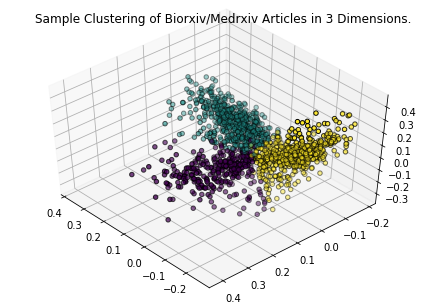

In [8]:
doclist = load_from_dirs([biomed])

# Stem document texts
# Use only first 1000 documents for testing
stem(doclist[:1000])

# Return array of feature vectors and store feature vectors in doc objects
mat = get_feature_vectors(doclist)

# Note: Batch size is arbitrary for the moment
result = reduce_dim(mat, method="ipca", n_dims=3, batch_size=100)

# Performing K-Means
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(result)

# 2 dimensional plotting
#y_kmeans = kmeans.predict(result)
# plt.scatter(result[:, 0], result[:, 1], c=y_kmeans, s=10, cmap='viridis')

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

# 3 dimensional plotting
fig = plt.figure()
fig.suptitle("Sample Clustering of Biorxiv/Medrxiv Articles in 3 Dimensions.")
y_vals = kmeans.predict(result)
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=138)
ax.scatter(result[:, 0], result[:, 1], result[:, 2], c=y_vals, edgecolor='k')
fig.show()

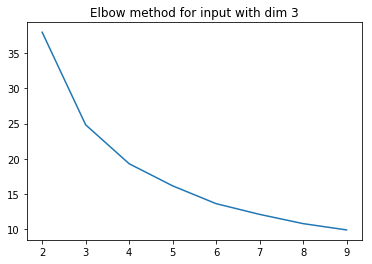

In [10]:
def elbow_method(data, min_clusters, max_clusters, n_dims):
    within_cluster_sum_distance = []
    k_vals = []
    for i in range(max_clusters - min_clusters):
        n_clusters = i + min_clusters
        k_vals.append(n_clusters)
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans = kmeans.fit(data)
        within_cluster_sum_distance.append(kmeans.inertia_)
    
    # Plot within-cluster sum of squared distances to determine optimal k-value
    plt.plot(k_vals, within_cluster_sum_distance)
    plt.title("Elbow method for input with dim {}".format(n_dims))
    plt.show()
        
elbow_method(result, 2, 10, n_dims=3)
# Using 3 clusters with the first 1000 articles appears to give the best clustering results

## Elbow method for k-means clustering with various input dimensions

Reading files from directory: /Users/ryersonburdick/Desktop/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json
Fitting ipca...
Transforming...


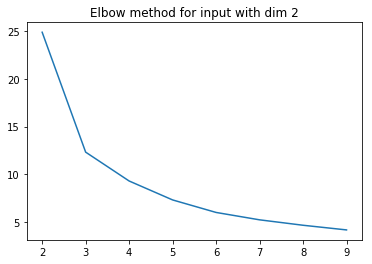

Fitting ipca...
Transforming...


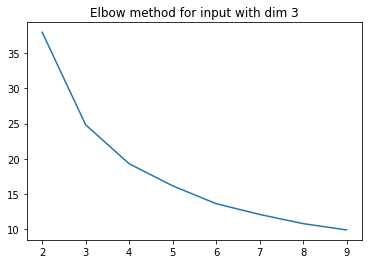

Fitting ipca...
Transforming...


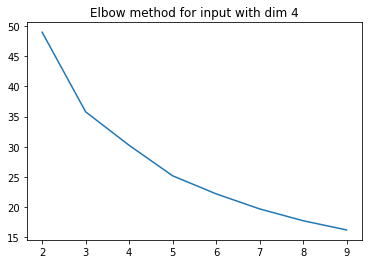

Fitting ipca...
Transforming...


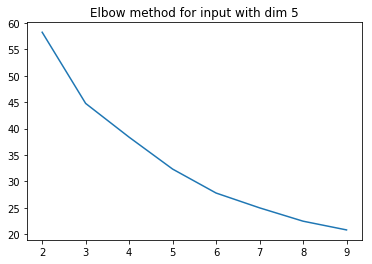

In [13]:
doclist = load_from_dirs([biomed])

# Stem document texts
# Use only first 1000 documents for testing
stem(doclist)

# Return array of feature vectors and store feature vectors in doc objects
mat = get_feature_vectors(doclist)

def n_dim_cluster_analysis(x, n_dims, min_clusters, max_clusters):
    # Reduce dim to desired input dim using IPCA
    result = reduce_dim(x, method="ipca", n_dims=n_dims, batch_size=100)
    elbow_method(result, min_clusters, max_clusters, n_dims=n_dims)
    

# Perform elbow method for input data with dim 2...5
for n_dims in [x+2 for x in range(4)]:
    n_dim_cluster_analysis(mat, n_dims, 2, 10)

The above graphs seem to suggest that for the first 1000 documents, 3 clusters in 2 dimensions has a decent clustering performance based on within-cluster sum of squared distances.

Fitting ipca...
Transforming...


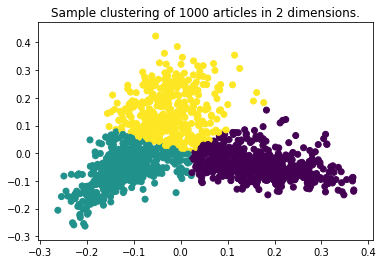

In [12]:
result = reduce_dim(mat, method='ipca', n_dims=2, batch_size=100)
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(result)
y_vals = kmeans.predict(result)

plt.figure()
plt.scatter(result[:, 0], result[:, 1], c=y_vals)
plt.title("Sample clustering of 1000 articles in 2 dimensions.")
plt.show()

## Encoding semantic information for arbitrarily long documents

A potential alternative approach may capture semantic information about a document by first storing the document
as a matrix of word embeddings. This matrix will be of size (L, E), where L is the length of the document in words and E is the size of the embedding for each word. If some operation can be performed to standardize (and reduce) the number of rows in this matrix to some document-invariant quantity Q, an embedding for this new matrix of size (Q, E) can be determined through a method such as a variational autoencoder. This document embedding can then be used for clustering. A word embedding method that captures semantic meaning should be chosen (e.g. word2vec or GloVe).

One potential method for reducing document matrix size is the encoder of a seq2seq model, though this may require a large context vector depending on document length.
See: https://www.inovex.de/blog/text-summarization-seq2seq-neural-networks/
A simpler method may be to only process a truncated version of each document, e.g. the first 1000 words.